In [1]:
import nmresearch as nmr # this loads data from brucker files 
import pickle # this loads data from saved numpy arrays

import numpy as np

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.linalg import expm

from sklearn import mixture

import matplotlib
import matplotlib.pyplot as plt

In [5]:
# decent color schemes for plots and such

colors=["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]

colors_single = ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#a63603','#7f2704']
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$ (a.u.)"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$ (a.u.)"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$ (a.u.)"

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

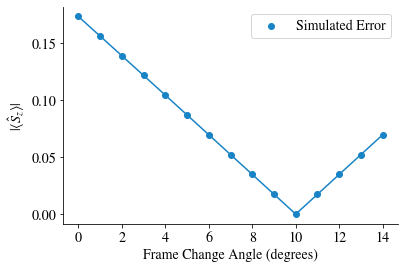

In [6]:
x = np.matrix([[0,1],[1,0]])
y = np.matrix([[0,-1j],[1j,0]])
z = np.matrix([[1,0],[0,-1]])

def Rz(theta):
    return expm(-1j*(theta/2)*z)

def Rphi(theta,phi):
    return expm(-1j*(theta/2)*(np.cos(phi)*x + np.sin(phi)*y))

def RphiExp(theta,phi):
    return Rphi(np.pi/18, phi+np.pi/2) @ Rphi(theta,phi)

# make sure things work

rho = np.array([[1,0],[0,0]])
np.trace(rho @ z)

# Experimental procedure: y, -x, <z>. Shift first pulse phase by a degree

def Uexp(eps):
    return RphiExp(np.pi/2, np.pi) @ RphiExp(np.pi/2, np.pi/2 + eps)

error = np.real([np.trace((Uexp(k*(np.pi/180)) @ rho @ Uexp(k*(np.pi/180)).conjugate().transpose()) @ z) for k in range(15)])

plt.plot(list(range(15)),abs(error), color=colors[0])
plt.scatter(list(range(15)),abs(error), label="Simulated Error", color=colors[0])
plt.xlabel("Frame Change Angle (degrees)")
plt.ylabel(r"$\left| \langle \hat{S}_z \rangle \right|$")
plt.xticks(np.arange(0, 15, step=2))
plt.legend()
plt.savefig("simulated_FC_error.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

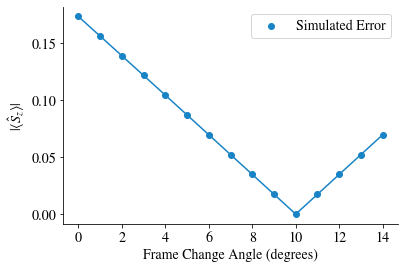

In [7]:
# 3Pi/2 Test
# Experimental procedure: y, -x, <z>. Shift first pulse phase by a degree

def Uexp(eps):
    return RphiExp(3*np.pi/2, np.pi) @ RphiExp(3*np.pi/2, np.pi/2 - eps)

error = np.real([np.trace((Uexp(k*(np.pi/180)) @ rho @ Uexp(k*(np.pi/180)).conjugate().transpose()) @ z) for k in range(15)])

plt.plot(list(range(15)),abs(error), color=colors[0])
plt.scatter(list(range(15)),abs(error), label="Simulated Error", color=colors[0])
plt.xlabel("Frame Change Angle (degrees)")
plt.ylabel(r"$\left| \langle \hat{S}_z \rangle \right|$")
plt.xticks(np.arange(0, 15, step=2))
plt.legend()
plt.savefig("simulated_FC_error.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

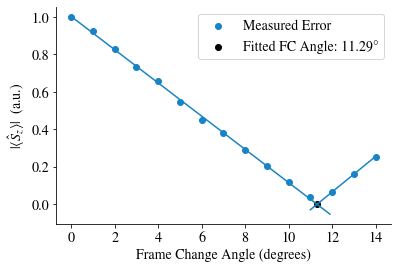

In [8]:
try:
    vals_cal = pickle.load(open("vals_cal.dat", "rb"))
except (OSError, IOError) as e:
    vals_cal = nmr.Experiment(601,folder="expt6").load_tpc3d(normalize=False)
    with open('vals_cal.dat', 'wb') as fi:
        pickle.dump(vals_cal, fi)

signal = sum(abs(vals_cal.transpose()))
normalized = signal/max(signal)

left = normalized[0:12]
right = normalized[12:]

p_left = np.polyfit(list(range(0,12)),left,1)
p_right = np.polyfit(list(range(12,15)),right, 1)

x_left = np.arange(0,12,.1)
x_right = np.arange(11,14,.1)

plt.plot(x_left, p_left[0]*x_left+p_left[1], color=colors[0])
plt.plot(x_right, p_right[0]*x_right+p_right[1], color=colors[0])
plt.scatter(list(range(12)),normalized[0:12], color=colors[0], label="Measured Error")
plt.scatter(list(range(12,15)),normalized[12:], color=colors[0])
plt.scatter(-p_left[1]/p_left[0],0,color='black',label="Fitted FC Angle: {:.2f}\xb0".format(-p_left[1]/p_left[0]))
plt.xlabel("Frame Change Angle (degrees)")
plt.ylabel(r"$\left| \langle \hat{S}_z\rangle \right|$  (a.u.)")
plt.xticks(np.arange(0, 15, step=2))
plt.legend()
plt.savefig("measured_FC_error.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

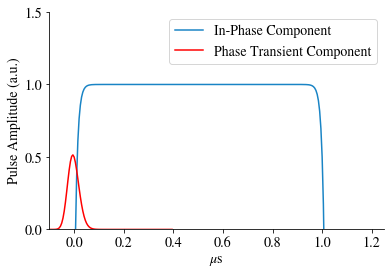

In [9]:
x = np.arange(-.02,2.05,.01)/2
a=.02
b=.1
c=-0.8
A=.01
pulse = 0.5*(1-np.exp(-(2*x-.025)/a))+0.5*(1-np.exp((2*x-2)/a))

x2 = np.arange(.01,1,.01)/2
tail = A/(2*x2*b)*np.exp(-(np.log(2*x2+.25)-c)**2 / (2*b**2))*np.exp(-(2*x2)**4)

plt.plot(x,pulse,label="In-Phase Component",color=colors[0])
plt.plot(x2-.1,tail,label="Phase Transient Component",color="red")
plt.ylim([0,1.5])
plt.xlim([-.1,1.25])
plt.xlabel(r"$\mu$s")
plt.ylabel("Pulse Amplitude (a.u.)")
plt.yticks([0,.5,1, 1.5])
plt.legend()
plt.savefig("pulse_shape.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

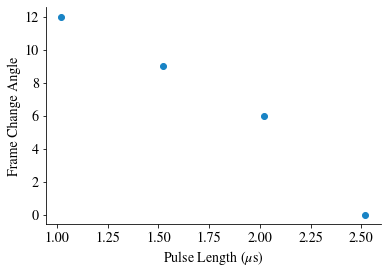

In [10]:
pulse_len = [1.02, 1.52, 2.02, 2.52]
fc_angle = [12,9,6,0]
plt.scatter(pulse_len,fc_angle,color=colors[0])
plt.xlabel(r"Pulse Length ($\mu$s)")
plt.ylabel("Frame Change Angle")
plt.show()

In [11]:
pulse_len = [1.02, 1.52, 2.02]

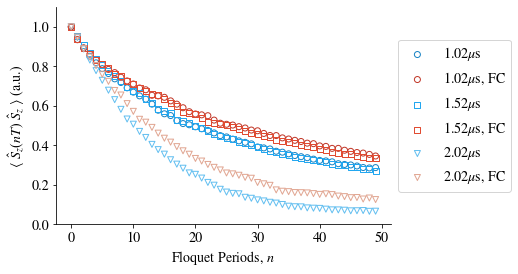

In [12]:
try:
    peng_zz_1 = pickle.load(open("peng_zz_1.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_1 = nmr.Experiment(64).load_tpc()
    with open('peng_zz_1.dat', 'wb') as fi:
        pickle.dump(peng_zz_1, fi)
        
try:
    peng_zz_2 = pickle.load(open("peng_zz_2.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_2 = nmr.Experiment(99).load_tpc()
    with open('peng_zz_2.dat', 'wb') as fi:
        pickle.dump(peng_zz_2, fi)
        
try:
    peng_zz_3 = pickle.load(open("peng_zz_3.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_3 = nmr.Experiment(172).load_tpc()
    with open('peng_zz_3.dat', 'wb') as fi:
        pickle.dump(peng_zz_3, fi)
        
        
try:
    peng_zz_fc_1 = pickle.load(open("peng_zz_fc_1.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_fc_1 = nmr.Experiment(65).load_tpc()
    with open('peng_zz_fc_1.dat', 'wb') as fi:
        pickle.dump(peng_zz_fc_1, fi)
        
try:
    peng_zz_fc_2 = pickle.load(open("peng_zz_fc_2.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_fc_2 = nmr.Experiment(100).load_tpc()
    with open('peng_zz_fc_2.dat', 'wb') as fi:
        pickle.dump(peng_zz_fc_2, fi)
        
try:
    peng_zz_fc_3 = pickle.load(open("peng_zz_fc_3.dat", "rb"))
except (OSError, IOError) as e:
    peng_zz_fc_3 = nmr.Experiment(173).load_tpc()
    with open('peng_zz_fc_3.dat', 'wb') as fi:
        pickle.dump(peng_zz_fc_3, fi)

periods = np.array(list(range(50)))      
        
plt.scatter(periods,peng_zz_1,label=str(pulse_len[0])+r"$\mu$s",color=colors[0],marker="o", facecolors='none')
plt.scatter(periods,peng_zz_fc_1,label=str(pulse_len[0])+r"$\mu$s, FC",color=colors[-1],marker="o", facecolors='none')

plt.scatter(periods,peng_zz_2,label=str(pulse_len[1])+r"$\mu$s",color=colors[1],marker="s", facecolors='none')
plt.scatter(periods,peng_zz_fc_2,label=str(pulse_len[1])+r"$\mu$s, FC",color=colors[-2],marker="s", facecolors='none')

plt.scatter(periods,peng_zz_3,label=str(pulse_len[2])+r"$\mu$s",color=colors[2],marker="v",facecolors='none')
plt.scatter(periods,peng_zz_fc_3,label=str(pulse_len[2])+r"$\mu$s, FC",color=colors[-4],marker="v",facecolors='none')

plt.ylabel(zcorr_str)
plt.xlabel("Floquet Periods, $n$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,1.1])

plt.savefig("peng_zz.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

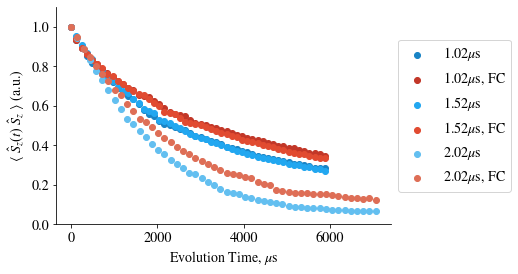

In [13]:
periods = np.array(list(range(50)))      

t5=24*5*periods
t6=24*6*periods

plt.scatter(t5,peng_zz_1,label=str(pulse_len[0])+r"$\mu$s",color=colors[0])
plt.scatter(t5,peng_zz_fc_1,label=str(pulse_len[0])+r"$\mu$s, FC",color=colors[-1])

plt.scatter(t5,peng_zz_2,label=str(pulse_len[1])+r"$\mu$s",color=colors[1])
plt.scatter(t5,peng_zz_fc_2,label=str(pulse_len[1])+r"$\mu$s, FC",color=colors[-2])

plt.scatter(t6,peng_zz_3,label=str(pulse_len[2])+r"$\mu$s",color=colors[2])
plt.scatter(t6,peng_zz_fc_3,label=str(pulse_len[2])+r"$\mu$s, FC",color=colors[-3])

plt.ylabel(r"$\langle$ $\hat{S}_z (t)$ $\hat{S}_z$ $\rangle$ (a.u.)")
plt.xlabel("Evolution Time, $\mu$s")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,1.1])

plt.savefig("peng_zz_alt.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

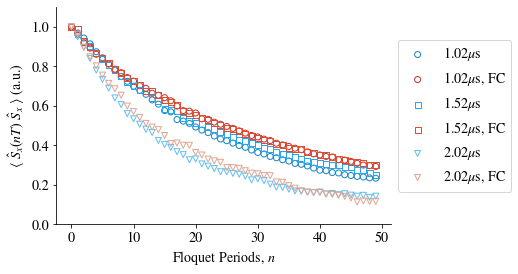

In [14]:
try:
    peng_xx_1 = pickle.load(open("peng_xx_1.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_1 = nmr.Experiment(66).load_tpc()
    with open('peng_xx_1.dat', 'wb') as fi:
        pickle.dump(peng_xx_1, fi)
        
try:
    peng_xx_2 = pickle.load(open("peng_xx_2.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_2 = nmr.Experiment(126).load_tpc()
    with open('peng_xx_2.dat', 'wb') as fi:
        pickle.dump(peng_xx_2, fi)
        
try:
    peng_xx_3 = pickle.load(open("peng_xx_3.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_3 = nmr.Experiment(169).load_tpc()
    with open('peng_xx_3.dat', 'wb') as fi:
        pickle.dump(peng_xx_3, fi)
        
        
try:
    peng_xx_fc_1 = pickle.load(open("peng_xx_fc_1.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_fc_1 = nmr.Experiment(67).load_tpc()
    with open('peng_xx_fc_1.dat', 'wb') as fi:
        pickle.dump(peng_xx_fc_1, fi)
        
try:
    peng_xx_fc_2 = pickle.load(open("peng_xx_fc_2.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_fc_2 = nmr.Experiment(127).load_tpc()
    with open('peng_xx_fc_2.dat', 'wb') as fi:
        pickle.dump(peng_xx_fc_2, fi)
        
try:
    peng_xx_fc_3 = pickle.load(open("peng_xx_fc_3.dat", "rb"))
except (OSError, IOError) as e:
    peng_xx_fc_3 = nmr.Experiment(170).load_tpc()
    with open('peng_xx_fc_3.dat', 'wb') as fi:
        pickle.dump(peng_xx_fc_3, fi)

periods = np.array(list(range(50)))      
        
plt.scatter(periods,peng_xx_1,label=str(pulse_len[0])+r"$\mu$s",color=colors[0],marker="o", facecolors='none')
plt.scatter(periods,peng_xx_fc_1,label=str(pulse_len[0])+r"$\mu$s, FC",color=colors[-1],marker="o", facecolors='none')

plt.scatter(periods,peng_xx_2,label=str(pulse_len[1])+r"$\mu$s",color=colors[1],marker="s", facecolors='none')
plt.scatter(periods,peng_xx_fc_2,label=str(pulse_len[1])+r"$\mu$s, FC",color=colors[-2],marker="s", facecolors='none')

plt.scatter(periods,peng_xx_3,label=str(pulse_len[2])+r"$\mu$s",color=colors[2],marker="v",facecolors='none')
plt.scatter(periods,peng_xx_fc_3,label=str(pulse_len[2])+r"$\mu$s, FC",color=colors[-4],marker="v",facecolors='none')

plt.ylabel(xcorr_str)
plt.xlabel("Floquet Periods, $n$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,1.1])

plt.savefig("peng_xx.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

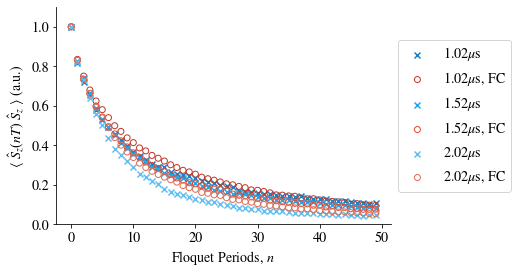

In [15]:
try:
    cory_zz_1 = pickle.load(open("cory_zz_1.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_1 = nmr.Experiment(23).load_tpc()
    with open('cory_zz_1.dat', 'wb') as fi:
        pickle.dump(cory_zz_1, fi)
        
try:
    cory_zz_2 = pickle.load(open("cory_zz_2.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_2 = nmr.Experiment(87).load_tpc()
    with open('cory_zz_2.dat', 'wb') as fi:
        pickle.dump(cory_zz_2, fi)
        
try:
    cory_zz_3 = pickle.load(open("cory_zz_3.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_3 = nmr.Experiment(154).load_tpc()
    with open('cory_zz_3.dat', 'wb') as fi:
        pickle.dump(cory_zz_3, fi)
        
        
try:
    cory_zz_fc_1 = pickle.load(open("cory_zz_fc_1.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_fc_1 = nmr.Experiment(33).load_tpc()
    with open('cory_zz_fc_1.dat', 'wb') as fi:
        pickle.dump(cory_zz_fc_1, fi)
        
try:
    cory_zz_fc_2 = pickle.load(open("cory_zz_fc_2.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_fc_2 = nmr.Experiment(88).load_tpc()
    with open('cory_zz_fc_2.dat', 'wb') as fi:
        pickle.dump(cory_zz_fc_2, fi)
        
try:
    cory_zz_fc_3 = pickle.load(open("cory_zz_fc_3.dat", "rb"))
except (OSError, IOError) as e:
    cory_zz_fc_3 = nmr.Experiment(155).load_tpc()
    with open('cory_zz_fc_3.dat', 'wb') as fi:
        pickle.dump(cory_zz_fc_3, fi)

periods = np.array(list(range(50)))      
        
plt.scatter(periods,cory_zz_1,label=str(pulse_len[0])+r"$\mu$s",color=colors[0],marker="x")
plt.scatter(periods,cory_zz_fc_1,label=str(pulse_len[0])+r"$\mu$s, FC",color=colors[-1],marker="o", facecolors='none')

plt.scatter(periods,cory_zz_2,label=str(pulse_len[1])+r"$\mu$s",color=colors[1],marker="x")
plt.scatter(periods,cory_zz_fc_2,label=str(pulse_len[1])+r"$\mu$s, FC",color=colors[-2],marker="o", facecolors='none')

plt.scatter(periods,cory_zz_3,label=str(pulse_len[2])+r"$\mu$s",color=colors[2],marker="x")
plt.scatter(periods,cory_zz_fc_3,label=str(pulse_len[2])+r"$\mu$s, FC",color=colors[-3],marker="o", facecolors='none')

plt.ylabel(zcorr_str)
plt.xlabel("Floquet Periods, $n$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,1.1])

plt.savefig("cory_zz.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

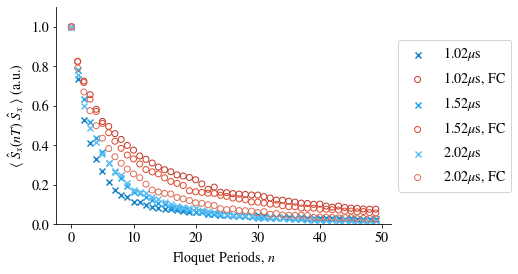

In [16]:
try:
    cory_xx_1 = pickle.load(open("cory_xx_1.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_1 = nmr.Experiment(76).load_tpc()
    with open('cory_xx_1.dat', 'wb') as fi:
        pickle.dump(cory_xx_1, fi)
        
try:
    cory_xx_2 = pickle.load(open("cory_xx_2.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_2 = nmr.Experiment(89).load_tpc()
    with open('cory_xx_2.dat', 'wb') as fi:
        pickle.dump(cory_xx_2, fi)
        
try:
    cory_xx_3 = pickle.load(open("cory_xx_3.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_3 = nmr.Experiment(156).load_tpc()
    with open('cory_xx_3.dat', 'wb') as fi:
        pickle.dump(cory_xx_3, fi)
        
        
try:
    cory_xx_fc_1 = pickle.load(open("cory_xx_fc_1.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_fc_1 = nmr.Experiment(75).load_tpc()
    with open('cory_xx_fc_1.dat', 'wb') as fi:
        pickle.dump(cory_xx_fc_1, fi)
        
try:
    cory_xx_fc_2 = pickle.load(open("cory_xx_fc_2.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_fc_2 = nmr.Experiment(90).load_tpc()
    with open('cory_xx_fc_2.dat', 'wb') as fi:
        pickle.dump(cory_xx_fc_2, fi)
        
try:
    cory_xx_fc_3 = pickle.load(open("cory_xx_fc_3.dat", "rb"))
except (OSError, IOError) as e:
    cory_xx_fc_3 = nmr.Experiment(159).load_tpc()
    with open('cory_xx_fc_3.dat', 'wb') as fi:
        pickle.dump(cory_xx_fc_3, fi)

periods = np.array(list(range(50)))      
        
plt.scatter(periods,cory_xx_1,label=str(pulse_len[0])+r"$\mu$s",color=colors[0],marker="x")
plt.scatter(periods,cory_xx_fc_1,label=str(pulse_len[0])+r"$\mu$s, FC",color=colors[-1],marker="o", facecolors='none')

plt.scatter(periods,cory_xx_2,label=str(pulse_len[1])+r"$\mu$s",color=colors[1],marker="x")
plt.scatter(periods,cory_xx_fc_2,label=str(pulse_len[1])+r"$\mu$s, FC",color=colors[-2],marker="o", facecolors='none')

plt.scatter(periods,cory_xx_3,label=str(pulse_len[2])+r"$\mu$s",color=colors[2],marker="x")
plt.scatter(periods,cory_xx_fc_3,label=str(pulse_len[2])+r"$\mu$s, FC",color=colors[-3],marker="o", facecolors='none')

plt.ylabel(xcorr_str)
plt.xlabel("Floquet Periods, $n$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0,1.1])

plt.savefig("cory_xx.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

In [17]:
def exp_fit(decay, show=False, c1=None, gauss=False, color="b", cycle=1, label_str=None):
    t = np.array(list(range(len(decay))))*cycle
    square = np.array([val**2 for val in t])
    tf = np.arange(0,t[-1],cycle/10)
    tfsq = np.array([val**2 for val in tf])
    if gauss:
        p = np.polyfit(square, np.log(decay), 1)
    else:
        p = np.polyfit(t, np.log(decay), 1)
        
    if label_str is not None:
        if gauss:
            if c1 is not None:
                plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=label_str,color=color)
                plt.scatter(t,decay,color=color)
            else:
                plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=label_str,color=color)
                plt.scatter(t,decay,color=color)
        else:
            if c1 is not None:
                plt.plot(tf, np.exp(p[0]*tf+p[1]), label=label_str,color=color)
                plt.scatter(t,decay,color=color)
            else:
                plt.plot(tf, np.exp(p[0]*tf+p[1]), label=label_str,color=color)
                plt.scatter(t,decay,color=color)
    else:
        if gauss:
            if c1 is not None:
                plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=r"$u = {:.2f}$, Fitted $\tau=${:.2f}".format(c1, np.sqrt(-1/p[0])),color=color)
                plt.scatter(t,decay,color=color)
            else:
                plt.plot(tf, np.exp(p[0]*tfsq+p[1]), label=r"Fitted $\tau=${:.2f}".format(np.sqrt(-1/p[0])),color=color)
                plt.scatter(t,decay,color=color)
        else:
            if c1 is not None:
                plt.plot(tf, np.exp(p[0]*tf+p[1]), label=r"$u = {:.2f}$, Fitted $\tau=${:.2f}".format(c1, -1/p[0]),color=color)
                plt.scatter(t,decay,color=color)
            else:
                plt.plot(tf, np.exp(p[0]*tf+p[1]), label=r"Fitted $\tau=${:.2f}".format(-1/p[0]),color=color)
                plt.scatter(t,decay,color=color)

    
    if show:
        plt.show() 
        plt.legend() 
        
    return np.sqrt(-1/p[0]) if gauss else -1/p[0]

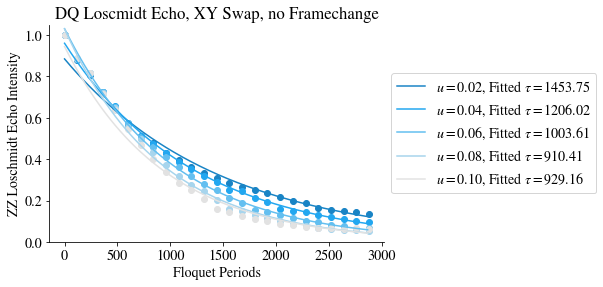

In [18]:
try:
    dq_echo = pickle.load(open("dq_echo.dat", "rb"))
except (OSError, IOError) as e:
    dq_echo = nmr.Experiment(612,folder='expt6').load_tpc3d()
    with open('dq_echo.dat', 'wb') as fi:
        pickle.dump(dq_echo, fi)

cnst1 = [0,.02,.04,.06,.08,.10]

swap_tau = []

for decay, c1, color in zip(dq_echo[1:], cnst1[1:], colors):
    swap_tau.append(exp_fit(decay, c1=c1, color=color,cycle=120))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.ylim([0,1.05])
plt.title("DQ Loscmidt Echo, XY Swap, no Framechange")
plt.savefig("echos.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

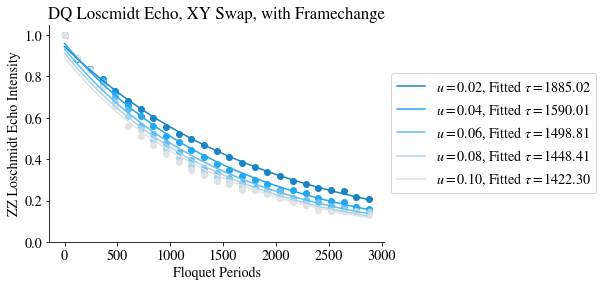

In [19]:
try:
    dq_echo_fc = pickle.load(open("dq_echo_fc.dat", "rb"))
except (OSError, IOError) as e:
    dq_echo_fc = nmr.Experiment(614,folder='expt6').load_tpc3d()
    with open('dq_echo_fc.dat', 'wb') as fi:
        pickle.dump(dq_echo_fc, fi)

cnst1 = [0,.02,.04,.06,.08,.10]

swap_fc_tau = []

for decay, c1, color in zip(dq_echo_fc[1:], cnst1[1:], colors):
    swap_fc_tau.append(exp_fit(decay, c1=c1, color=color,cycle=120))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel("Floquet Periods")
plt.ylabel("ZZ Loschmidt Echo Intensity")
plt.ylim([0,1.05])
plt.title("DQ Loscmidt Echo, XY Swap, with Framechange")
plt.savefig("echos_fc.pdf",format='pdf',dpi=900,bbox_inches='tight')

plt.show()

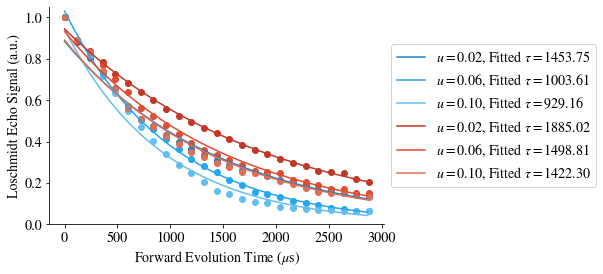

In [20]:
cnst1 = [0,.02,.04,.06,.08,.10]

for decay, c1, color in zip(dq_echo[1:6:2], cnst1[1:6:2], colors):
    exp_fit(decay, c1=c1, color=color,cycle=120)
    
colors.reverse()
for decay, c1, color in zip(dq_echo_fc[1:6:2], cnst1[1:6:2], colors):
    exp_fit(decay, c1=c1, color=color,cycle=120)
colors.reverse()


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.xlabel(r"Forward Evolution Time ($\mu$s)")
plt.ylabel("Loschmidt Echo Signal (a.u.)")
plt.ylim([0,1.05])
plt.savefig("loschmidt_decay.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

In [21]:
cnst1[1:6:2]

[0.02, 0.06, 0.1]

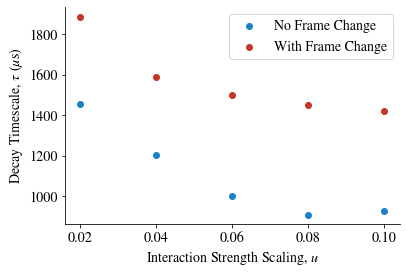

In [22]:
plt.scatter(cnst1[1:],swap_tau,label="No Frame Change",color=colors[0])
plt.scatter(cnst1[1:],swap_fc_tau,label="With Frame Change",color=colors[-1])
plt.xlabel(r"Interaction Strength Scaling, $u$")
plt.ylabel(r"Decay Timescale, $\tau$ ($\mu$s)")
plt.legend()
plt.savefig("echo_timescales.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

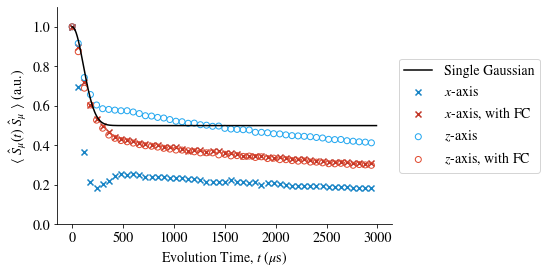

In [23]:
# 1.02 us pulse length

try:
    mrevXZ_zz = pickle.load(open("mrevXZ_zz.dat", "rb"))
except (OSError, IOError) as e:
    mrevXZ_zz = nmr.Experiment(183).load_tpc()
    with open('mrevXZ_zz.dat', 'wb') as fi:
        pickle.dump(mrevXZ_zz, fi)
        
try:
    mrevXZ_xx = pickle.load(open("mrevXZ_xx.dat", "rb"))
except (OSError, IOError) as e:
    mrevXZ_xx = nmr.Experiment(184).load_tpc()
    with open('mrevXZ_xx.dat', 'wb') as fi:
        pickle.dump(mrevXZ_xx, fi)
        
try:
    mrevXZ_zz_fc = pickle.load(open("mrevXZ_zz_fc.dat", "rb"))
except (OSError, IOError) as e:
    mrevXZ_zz_fc = nmr.Experiment(185).load_tpc()
    with open('mrevXZ_zz_fc.dat', 'wb') as fi:
        pickle.dump(mrevXZ_zz_fc, fi)
        
try:
    mrevXZ_xx_fc = pickle.load(open("mrevXZ_xx_fc.dat", "rb"))
except (OSError, IOError) as e:
    mrevXZ_xx_fc = nmr.Experiment(186).load_tpc()
    with open('mrevXZ_xx_fc.dat', 'wb') as fi:
        pickle.dump(mrevXZ_xx_fc, fi)
        
# (J^(FP) = 0.5 * 6.069 krad/s. 

h = (np.pi) *6.069 * 10**-3 # from single gaussian fit in cell below
t = np.arange(0,60*50, 60)
tsmooth = np.arange(0,60*50, 10)
plt.plot(tsmooth,1/2+1/2*np.exp(-(h*tsmooth/3)**2),label="Single Gaussian",color="black")

#mu_sym = np.array([-9,-3,3,9])*2*np.pi*10**-3
#sigma_sym = np.array([2.1,2.7,2.7,2.1])*2*np.pi*10**-3
#weight_sym = np.array([1/6,1/3,1/3,1/6])
#sig_sym = .5+.5*sum([w*np.exp(-(sig*t/3)**2)*np.cos(np.sqrt(2)*mean*t/3) for mean,sig,w in zip(mu_sym,sigma_sym,weight_sym)])
#plt.plot(t,sig_sym,label=" Symmetrized Gaussian Mixture Model",color="black")

# Raw Fitting
#mu = np.array([-8.98057309,  2.93716208, -3.0154291 ,  8.89144307])*2*np.pi*10**-3
#sigma = np.array([2.65389624, 2.14059816, 2.12263459, 2.68951638])*2*np.pi*10**-3
#weight = np.array([0.15704964, 0.34124437, 0.34036266, 0.16134333])
#sig = .5+.5*sum([w*np.exp(-(sig*t/3)**2)*np.cos(np.sqrt(2)*mean*t/3) for mean,sig,w in zip(mu,sigma,weight)])
#plt.plot(t,sig,label=" Raw Gaussian Mixture Model",color="orange")


plt.scatter(t,mrevXZ_xx,label=r"$x$-axis",color=colors[0],marker='x')
plt.scatter(t,mrevXZ_xx_fc, label=r"$x$-axis, with FC",color=colors[-1],marker='x')

plt.scatter(t,mrevXZ_zz,label=r"$z$-axis",color=colors[1],marker="o", facecolors='none')
plt.scatter(t,mrevXZ_zz_fc, label=r"$z$-axis, with FC",color=colors[-2],marker="o", facecolors='none')


plt.ylim([0,1.1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r"Evolution Time, $t$ ($\mu$s)")
plt.ylabel(r"$\langle$ $\hat{S}_\mu (t)$ $\hat{S}_\mu$ $\rangle$ (a.u.)")
plt.savefig("mrev_coincidence.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()

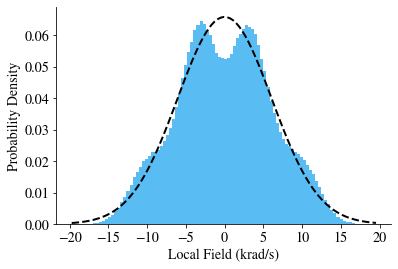

In [24]:
try:
    FaP_distro = pickle.load(open("FaP_distro_1e6.dat", "rb"))
except (OSError, IOError) as e:
    print("Please recompute in the relevant notebook")

    
# best Gaussian fit of data
(mu, sigma) = norm.fit(FaP_distro/1000)

# the histogram of the data
n, bins, patches = plt.hist(FaP_distro/1000, 100, density=True, facecolor=colors[1], alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=2, label=r'Gaussian Fit: $\mu=%.3f, \sigma=%.3f$' %(mu, sigma))

#plot
plt.xlabel('Local Field (krad/s)')
plt.ylabel('Probability Density')
#plt.title(r'$\mathrm{PDF\ of\ Local\ Field:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([-20,-15,-10,-5,0,5,10,15,20])


plt.savefig("FaP_LocalField_Distro.pdf",format='pdf',dpi=900,bbox_inches='tight')


plt.show()

In [25]:
x = np.array(FaP_distro/1000).reshape(-1,1)

clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(x)

GaussianMixture(n_components=4)

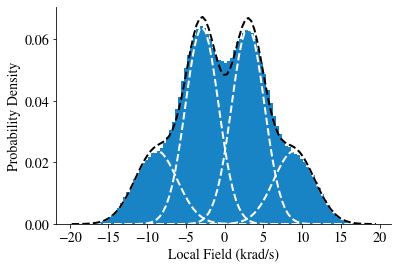

In [26]:
# the histogram of the data
n, bins, patches = plt.hist(FaP_distro/1000, 100, density=True, color=colors[0])

#plot
plt.xlabel('Local Field (krad/s)')
plt.xticks([-20,-15,-10,-5,0,5,10,15,20])
plt.ylabel('Probability Density')


y0 = norm.pdf(bins,clf.means_[0,0], clf.covariances_[0,0,0]**.5)
plt.plot(bins, y0*clf.weights_[0], 'w--', linewidth=2,label="Fitted Features")

y1 = norm.pdf(bins,clf.means_[1,0], clf.covariances_[1,0,0]**.5)
plt.plot(bins, y1*clf.weights_[1], 'w--', linewidth=2)

y2 = norm.pdf(bins,clf.means_[2,0], clf.covariances_[2,0,0]**.5)
plt.plot(bins, y2*clf.weights_[2], 'w--', linewidth=2)

y3 = norm.pdf(bins,clf.means_[3,0], clf.covariances_[3,0,0]**.5)
plt.plot(bins, y3*clf.weights_[3], 'w--', linewidth=2)

y_sum = y1*clf.weights_[1]+y0*clf.weights_[0]+y2*clf.weights_[2]+y3*clf.weights_[3]

plt.plot(bins,y_sum,'k--', linewidth=2,label="Fitted PDF")

plt.show()

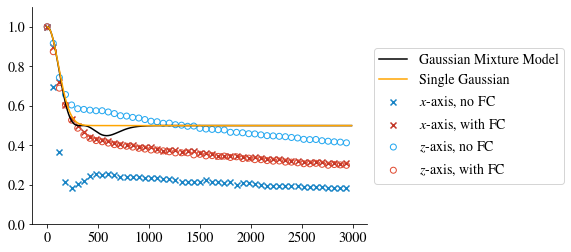

In [27]:
mu = (clf.means_[:,0])*np.pi*10**-3
sigma = (clf.covariances_[:,0,0]**.5)*np.pi*10**-3
weight = clf.weights_

tsmooth = np.arange(0,60*50, 10)

sig = .5+.5*sum([w*np.exp(-(sig*tsmooth/3)**2)*np.cos(np.sqrt(2)*mean*tsmooth/3) for mean,sig,w in zip(mu,sigma,weight)])
plt.plot(tsmooth,sig,label="Gaussian Mixture Model",color="black")

h = (np.pi) * 6.069 * 10**-3 # from single gaussian fit in cell below
t = np.arange(0,60*50, 60)
tsmooth = np.arange(0,60*50, 10)
plt.plot(tsmooth,1/2+1/2*np.exp(-(h*tsmooth/3)**2),label="Single Gaussian",color="orange")

plt.scatter(t,mrevXZ_xx,label=r"$x$-axis, no FC",color=colors[0],marker='x')
plt.scatter(t,mrevXZ_xx_fc, label=r"$x$-axis, with FC",color=colors[-1],marker='x')

plt.scatter(t,mrevXZ_zz,label=r"$z$-axis, no FC",color=colors[1],marker="o", facecolors='none')
plt.scatter(t,mrevXZ_zz_fc, label=r"$z$-axis, with FC",color=colors[-2],marker="o", facecolors='none')

plt.ylim([0,1.1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

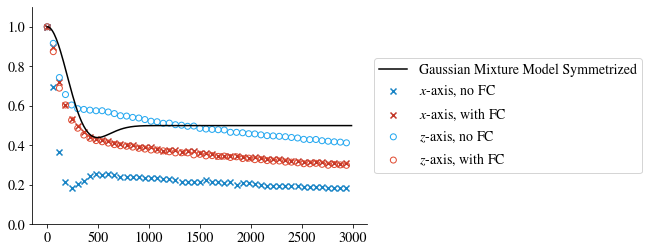

In [28]:
mu_far = (mu[0]-mu[3])/2
mu_close = (mu[2]-mu[1])/2

sigma_far = (sigma[0]+sigma[3])/2
sigma_close = (sigma[2]+sigma[1])/2

weight_far = (weight[0]+weight[3])/2
weight_close = (weight[2]+weight[1])/2

mu_sym = np.array([-mu_far, -mu_close, mu_close, mu_far])
sigma_sym = np.array([sigma_far,sigma_close, sigma_close,sigma_far])
weight_sym = np.array([weight_far,weight_close, weight_close,weight_far])

tsmooth = np.arange(0,60*50, 10)

sig = .5+.5*sum([w*np.exp(-(sig*tsmooth/3)**2)*np.cos(np.sqrt(2)*mean*tsmooth/3) for mean,sig,w in zip(mu_sym,sigma_sym,weight_sym)])
plt.plot(tsmooth,sig,label="Gaussian Mixture Model Symmetrized",color="black")

plt.scatter(t,mrevXZ_xx,label=r"$x$-axis, no FC",color=colors[0],marker='x')
plt.scatter(t,mrevXZ_xx_fc, label=r"$x$-axis, with FC",color=colors[-1],marker='x')

plt.scatter(t,mrevXZ_zz,label=r"$z$-axis, no FC",color=colors[1],marker="o", facecolors='none')
plt.scatter(t,mrevXZ_zz_fc, label=r"$z$-axis, with FC",color=colors[-2],marker="o", facecolors='none')

plt.ylim([0,1.1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

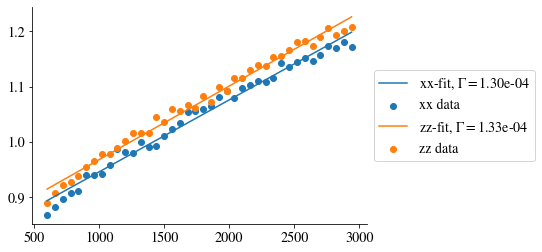

In [29]:
t_flat = t[10:]
xx_flat = -np.log(mrevXZ_xx_fc)[10:]
zz_flat = -np.log(mrevXZ_zz_fc)[10:]

p_xx = np.polyfit(t_flat, xx_flat, 1)
p_zz = np.polyfit(t_flat, zz_flat, 1)


plt.plot(t_flat, p_xx[0]*t_flat+p_xx[1],label=r"xx-fit, $\Gamma=${:.2e}".format(p_xx[0]))
plt.scatter(t_flat,xx_flat,label="xx data")

plt.plot(t_flat, p_zz[0]*t_flat+p_zz[1],label=r"zz-fit, $\Gamma=${:.2e}".format(p_zz[0]))
plt.scatter(t_flat,zz_flat,label="zz data")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

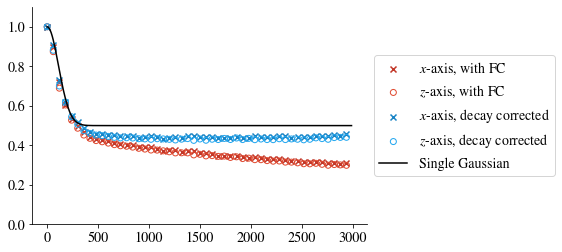

In [30]:
Gamma = (p_xx[0]+p_zz[0])/2
decay = np.exp(-Gamma*t)

plt.scatter(t,mrevXZ_xx_fc, label=r"$x$-axis, with FC",color=colors[-1],marker='x')
plt.scatter(t,mrevXZ_zz_fc, label=r"$z$-axis, with FC",color=colors[-2],marker="o", facecolors='none')

plt.scatter(t,mrevXZ_xx_fc/decay, label=r"$x$-axis, decay corrected",color=colors[0],marker='x')
plt.scatter(t,mrevXZ_zz_fc/decay, label=r"$z$-axis, decay corrected",color=colors[1],marker="o", facecolors='none')

plt.plot(tsmooth,1/2+1/2*np.exp(-((h)*tsmooth/3)**2),label="Single Gaussian",color="black")

plt.ylim([0,1.1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

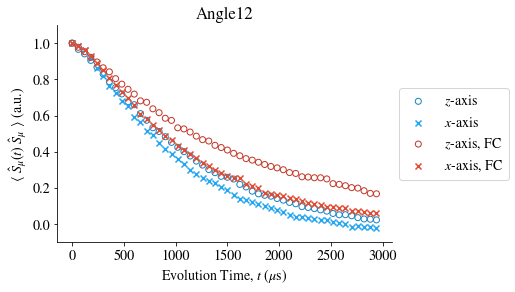

In [35]:
try:
    ang12_zz = pickle.load(open("ang12_zz.dat", "rb"))
except (OSError, IOError) as e:
    ang12_zz = nmr.Experiment(250).load_tpc()
    with open('ang12_zz.dat', 'wb') as fi:
        pickle.dump(ang12_zz, fi)

try:
    ang12_zz_fc = pickle.load(open("ang12_zz_fc.dat", "rb"))
except (OSError, IOError) as e:
    ang12_zz_fc = nmr.Experiment(251).load_tpc()
    with open('ang12_zz_fc.dat', 'wb') as fi:
        pickle.dump(ang12_zz_fc, fi)
        
try:
    ang12_xx = pickle.load(open("ang12_xx.dat", "rb"))
except (OSError, IOError) as e:
    ang12_xx = nmr.Experiment(282).load_tpc()
    with open('ang12_xx.dat', 'wb') as fi:
        pickle.dump(ang12_xx, fi)
try:
    ang12_xx_fc = pickle.load(open("ang12_xx_fc.dat", "rb"))
except (OSError, IOError) as e:
    ang12_xx_fc = nmr.Experiment(283).load_tpc()
    with open('ang12_xx_fc.dat', 'wb') as fi:
        pickle.dump(ang12_xx_fc, fi)
        
cycles = len(ang12_zz)
t = np.arange(0,60*cycles,60)

plt.scatter(t,ang12_zz,label=r"$z$-axis",color=colors[0],marker='o', facecolors='none')
plt.scatter(t,ang12_xx,label=r"$x$-axis",color=colors[1],marker='x')

plt.scatter(t,ang12_zz_fc, label=r"$z$-axis, FC",color=colors[-1],marker='o', facecolors='none')
plt.scatter(t,ang12_xx_fc, label=r"$x$-axis, FC",color=colors[-2],marker='x')

plt.ylim([-.1,1.1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r"Evolution Time, $t$ ($\mu$s)")
plt.ylabel(r"$\langle$ $\hat{S}_\mu (t)$ $\hat{S}_\mu$ $\rangle$ (a.u.)")
plt.title("Angle12")
plt.savefig("angle12_102.pdf",format='pdf',dpi=900,bbox_inches='tight')
plt.show()